In [1]:
from joblib import load
import numpy as np
import matplotlib.pyplot as plt

In [3]:
importance = load('../data/elec2/importance.joblib')

In [4]:
arange = 150
difference = load('../data/elec2/difference.joblib')[:arange]
cum = np.cumsum(difference)[:arange]
x = np.arange(arange)

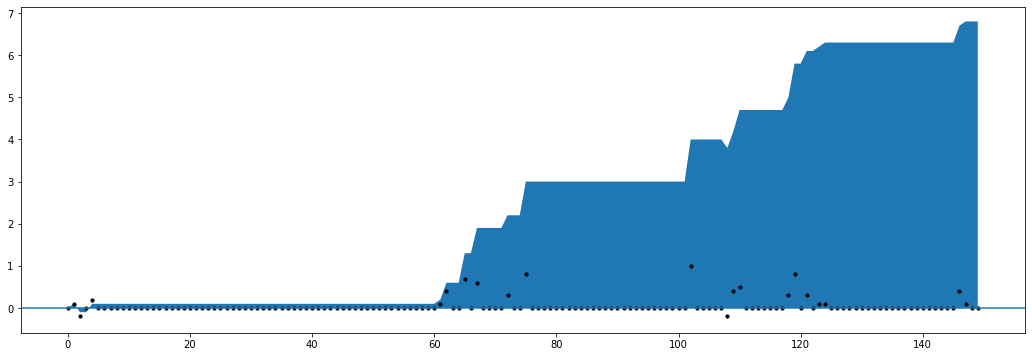

In [5]:
plt.figure(figsize=(18, 6))
plt.fill_between(x, cum, 0)
plt.scatter(x, difference, s=10, c='black')
plt.axhline(0)

In [6]:
print(cum[-10:])

[6.3 6.3 6.3 6.3 6.3 6.3 6.7 6.8 6.8 6.8]


In [7]:
with open('../elec2.output') as fin:
    print(fin.read())

[FINETUNING BASE MODELS]
[GENERATE METAFEATURE]
Frequency statistics in metabase:
	SVC                      0.530
	RandomForestClassifier   0.400
	GaussianNB               0.070
[OFFLINE LEARNING]
Kappa:    0.029
GMean:    0.000
Accuracy: 0.493
[[105  53   1]
 [ 74  43   3]
 [ 12   9   0]]
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       159
           1       0.41      0.36      0.38       120
           2       0.00      0.00      0.00        21

    accuracy                           0.49       300
   macro avg       0.32      0.34      0.33       300
weighted avg       0.46      0.49      0.47       300

                   pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.66      0.39      0.60      0.51      0.26       159
          1       0.41      0.36      0.66      0.38      0.48      0.23       120
          2       0.00      0.00      0.99      0.00      0.00      0.00      